In [1]:
library(tidyr)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
similarity <- read.csv('../../interneuron-reward-data/processed/ideal_projection_similarity.csv')

# Convert numeric cell_id to factor
similarity[, 'day'] <- as.factor(similarity[, 'day'])
similarity[, 'cell_id'] <- as.factor(similarity[, 'cell_id'])

# Display first few rows
head(similarity)

day,cell_type,cell_id,mouse_id,tone,tone...delay,delay,reward
1,vip,3121,CL136,0.15673343,-0.02025768,-0.153783321,-0.164965563
7,vip,3121,CL136,-0.12500414,-0.05046338,0.040303536,-0.268219990
1,vip,3122,CL136,0.31555878,0.18300207,-0.032999655,-0.467529018
7,vip,3122,CL136,-0.16381732,-0.36659268,-0.318575664,-0.044840419
1,vip,3123,CL136,0.12944190,0.07552554,-0.012969963,-0.006139394
7,vip,3123,CL136,0.04045443,0.03288791,0.007422192,-0.064749027


In [4]:
similarity %>% gather("trial_component", 'tuning', 'tone...delay', 'reward') %>% head

day,cell_type,cell_id,mouse_id,tone,delay,trial_component,tuning
1,vip,3121,CL136,0.15673343,-0.153783321,tone...delay,-0.02025768
7,vip,3121,CL136,-0.12500414,0.040303536,tone...delay,-0.05046338
1,vip,3122,CL136,0.31555878,-0.032999655,tone...delay,0.18300207
7,vip,3122,CL136,-0.16381732,-0.318575664,tone...delay,-0.36659268
1,vip,3123,CL136,0.12944190,-0.012969963,tone...delay,0.07552554
7,vip,3123,CL136,0.04045443,0.007422192,tone...delay,0.03288791


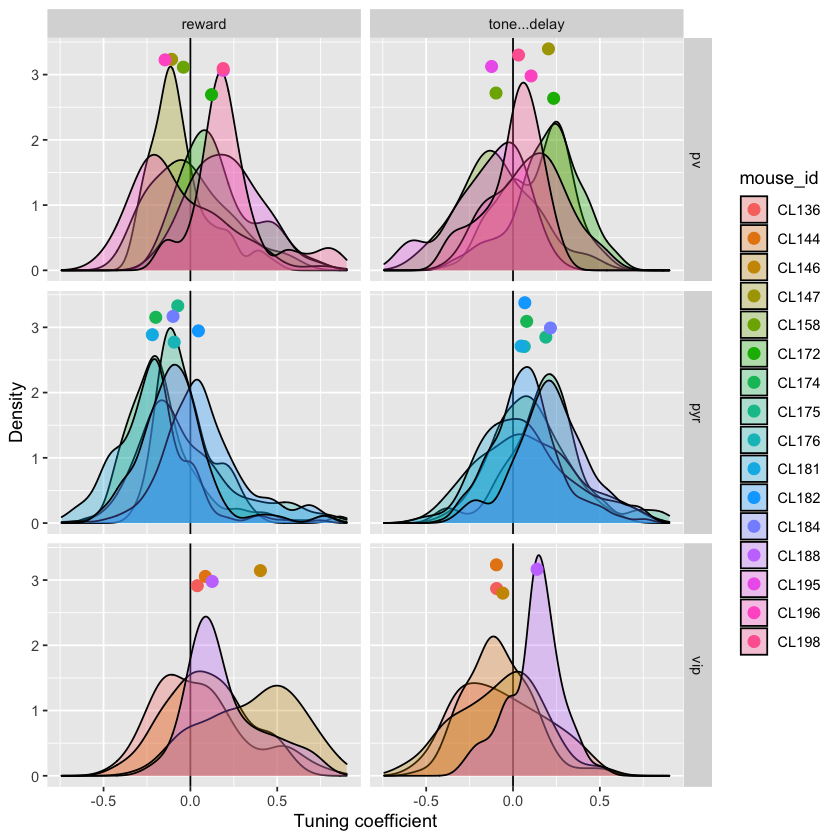

In [9]:
similarity_long <- similarity %>% gather("trial_component", 'tuning', 'tone...delay', 'reward')

per_mouse_similarity <- (
    ggplot(
        cbind(
            similarity_long[similarity_long$day == 7, ], 
            data.frame(y=rep(3, nrow(similarity_long[similarity_long$day == 7, ])))
        ), 
        aes(x=tuning, fill=mouse_id)
    )
    + facet_grid(rows=vars(cell_type), cols=vars(trial_component))
    + geom_vline(xintercept=0)
    + geom_density(alpha=0.3)
    + stat_summary(
        aes(y=y, color=mouse_id), 
        fun=median, fun.min=median, fun.max=median, 
        geom='point', position='jitter', size=3,
        orientation='y'
    )
    + labs(y='Density', x='Tuning coefficient')
)

ggsave(file='../img/graphics/per_mouse_similarity.svg', plot=per_mouse_similarity, width=6, height=6)

per_mouse_similarity

In [3]:
difference_dfs <- list()

for (response_variable in c('reward', 'tone...delay')) {
    difference <- (
        similarity[, c('day', 'cell_id', 'cell_type', 'mouse_id', response_variable)] 
        %>% spread(day, response_variable)
    )
    difference[, 'tuning_change'] <- difference[,"7"] - difference[,"1"]
    difference <- difference[, !(colnames(difference) %in% c("1", "7"))]
    
    difference_dfs[[response_variable]] <- difference
}

In [4]:
difference_dfs[['reward']][, 'trial_component'] <- 'Reward tuning'
difference_dfs[['tone...delay']][, 'trial_component'] <- 'Tone tuning'

difference <- rbind(difference_dfs[['reward']], difference_dfs[['tone...delay']])
head(difference)

cell_id,cell_type,mouse_id,tuning_change,trial_component
1,pyr,CL174,0.03077134,Reward tuning
2,pyr,CL174,0.26060798,Reward tuning
3,pyr,CL174,-0.41371420,Reward tuning
4,pyr,CL174,-0.31064693,Reward tuning
5,pyr,CL174,0.65019971,Reward tuning
6,pyr,CL174,0.51331267,Reward tuning


In [5]:
summary(difference)

    cell_id     cell_type     mouse_id    tuning_change      trial_component   
 1      :   2   pv : 624   CL176  : 598   Min.   :-1.19299   Length:3852       
 2      :   2   pyr:2414   CL182  : 510   1st Qu.:-0.24631   Class :character  
 3      :   2   vip: 814   CL174  : 422   Median :-0.01262   Mode  :character  
 4      :   2              CL184  : 372   Mean   :-0.01067                     
 5      :   2              CL181  : 366   3rd Qu.: 0.21912                     
 6      :   2              CL136  : 240   Max.   : 1.33728                     
 (Other):3840              (Other):1344   NA's   :2                            

In [8]:
per_mouse_similarity_change <- (
    ggplot(cbind(difference, data.frame(y=rep(2.2, nrow(difference)))), aes(x=tuning_change, fill=mouse_id))
    + facet_grid(rows=vars(cell_type), cols=vars(trial_component))
    + geom_vline(xintercept=0)
    + geom_density(alpha=0.3)
    + stat_summary(
        aes(y=y, color=mouse_id), 
        fun=median, fun.min=median, fun.max=median, 
        geom='point', position='jitter', size=3,
        orientation='y'
    )
    + labs(y='Density', x='Change from day 1 to day 7')
)

ggsave(file='../img/graphics/per_mouse_similarity_change.svg', plot=per_mouse_similarity_change, width=6, height=6)

per_mouse_similarity_change

Warning message:
“Removed 2 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”

In [7]:
difference_stats <- list()
num_mice <- length(unique(difference[, 'mouse_id']))

for (trial_component in unique(difference[, 'trial_component'])) {
    # Allocate data frame for storing p-values
    difference_stats[[trial_component]] <- data.frame(
        mouse_id=unique(difference[, 'mouse_id']), 
        cell_type=factor(character(num_mice), levels=levels(difference[, 'cell_type'])), 
        greater_p_value=numeric(num_mice),
        less_p_value=numeric(num_mice)
    )

    for (mouse_id in unique(difference[, 'mouse_id'])) {
        # Compute masks for selecting data
        this_row_mask <- (difference_stats[[trial_component]][, 'mouse_id'] == mouse_id)
        diff_row_mask <- (
            (difference[, 'mouse_id'] == mouse_id) 
            & (difference[, 'trial_component'] == trial_component)
        )
        
        # Store cell type
        difference_stats[[trial_component]][this_row_mask, 'cell_type'] <- difference[
            diff_row_mask, 'cell_type'
        ][1]
        
        # Compute p-values for positive or negative tuning change
        difference_stats[[trial_component]][this_row_mask, 'greater_p_value'] <- wilcox.test(
            difference[diff_row_mask, 'tuning_change'], 
            alternative='greater'
        )$p.value
        difference_stats[[trial_component]][this_row_mask, 'less_p_value'] <- wilcox.test(
            difference[diff_row_mask, 'tuning_change'], 
            alternative='less'
        )$p.value
    }
    
    difference_stats[[trial_component]][, 'trial_component'] <- trial_component
}

difference_stats <- rbind(difference_stats[['Reward tuning']], difference_stats[['Tone tuning']])

In [8]:
difference_stats[, 'greater_significance'] <- difference_stats[, 'greater_p_value'] < 0.05
difference_stats[, 'less_significance'] <- difference_stats[, 'less_p_value'] < 0.05

any(difference_stats[, 'greater_significance'] & difference_stats[, 'less_significance'])

[1] FALSE

If the above outputs `FALSE`, there are no mice that exhibit *both* a significant increase and decrease in tuning. This is a sanity check and `FALSE` is the expected result.

In [9]:
signif_counts <- merge(
    merge(
        aggregate(
            rep(1, nrow(difference_stats)), 
            by=list(difference_stats$cell_type, difference_stats$trial_component), 
            FUN=sum
        ) %>% rename(num_mice=x, cell_type=Group.1, trial_component=Group.2),
        aggregate(
            difference_stats$greater_significance, 
            by=list(difference_stats$cell_type, difference_stats$trial_component), 
            FUN=sum
        ) %>% rename(num_greater_signif=x, cell_type=Group.1, trial_component=Group.2)
    ),
    aggregate(
        difference_stats$less_significance, 
        by=list(difference_stats$cell_type, difference_stats$trial_component), 
        FUN=sum
    ) %>% rename(num_less_signif=x, cell_type=Group.1, trial_component=Group.2)
)

signif_counts

cell_type,trial_component,num_mice,num_greater_signif,num_less_signif
pv,Reward tuning,6,3,3
pv,Tone tuning,6,1,3
pyr,Reward tuning,6,1,4
pyr,Tone tuning,6,3,1
vip,Reward tuning,4,3,1
vip,Tone tuning,4,1,3


In [10]:
omnibus_test <- function(num_significant_p_values, num_tests, alpha_level) {
    if (num_significant_p_values == 0) {
        return(1.0)
    } else {
        return(
            pbinom(num_significant_p_values - 1, num_tests, alpha_level, lower.tail=FALSE)
        )
    }
}

In [11]:
signif_counts[, 'greater_signif_p'] <- apply(
    signif_counts, 1, 
    function(row) omnibus_test(as.numeric(row['num_greater_signif']), as.numeric(row['num_mice']), 0.05)
)
signif_counts[, 'greater_signif_flag_bonferroni'] <- signif_counts[, 'greater_signif_p'] < (0.05 / 12)

signif_counts[, 'less_signif_p'] <- apply(
    signif_counts, 1, 
    function(row) omnibus_test(as.numeric(row['num_less_signif']), as.numeric(row['num_mice']), 0.05)
)
signif_counts[, 'less_signif_flag_bonferroni'] <- signif_counts[, 'less_signif_p'] < (0.05 / 12)

signif_counts

cell_type,trial_component,num_mice,num_greater_signif,num_less_signif,greater_signif_p,greater_signif_flag_bonferroni,less_signif_p,less_signif_flag_bonferroni
pv,Reward tuning,6,3,3,0.002229844,TRUE,2.229844e-03,TRUE
pv,Tone tuning,6,1,3,0.264908109,FALSE,2.229844e-03,TRUE
pyr,Reward tuning,6,1,4,0.264908109,FALSE,8.640625e-05,TRUE
pyr,Tone tuning,6,3,1,0.002229844,TRUE,2.649081e-01,FALSE
vip,Reward tuning,4,3,1,0.000481250,TRUE,1.854938e-01,FALSE
vip,Tone tuning,4,1,3,0.185493750,FALSE,4.812500e-04,TRUE


After Bonferroni correction for 12 comparisons, we find the following:
- PV 
    - become activated or inhibited by reward, depending on the mouse
    - become inhibited by tone in at least some mice
- PYR
    - become inhibited by reward in at least some mice
    - become activated by tone in at least some mice
- VIP
    - become activated by reward in at least some mice
    - become inhibited by tone in at least some mice

In [12]:
median_differences <- aggregate(
    difference$tuning_change, 
    by=list(difference$cell_type, difference$mouse_id, difference$trial_component),
    FUN=function(x) median(x, na.rm=TRUE)
) %>% rename(cell_type=Group.1, mouse_id=Group.2, trial_component=Group.3, tuning_change=x)

aggregate(
    median_differences$tuning_change,
    by=list(median_differences$cell_type, median_differences$trial_component),
    FUN=function(x) wilcox.test(x, alternative='two.sided')$p.value
)

Group.1,Group.2,x
pv,Reward tuning,0.84375
pyr,Reward tuning,0.15625
vip,Reward tuning,0.37500
pv,Tone tuning,0.56250
pyr,Tone tuning,0.43750
vip,Tone tuning,0.37500


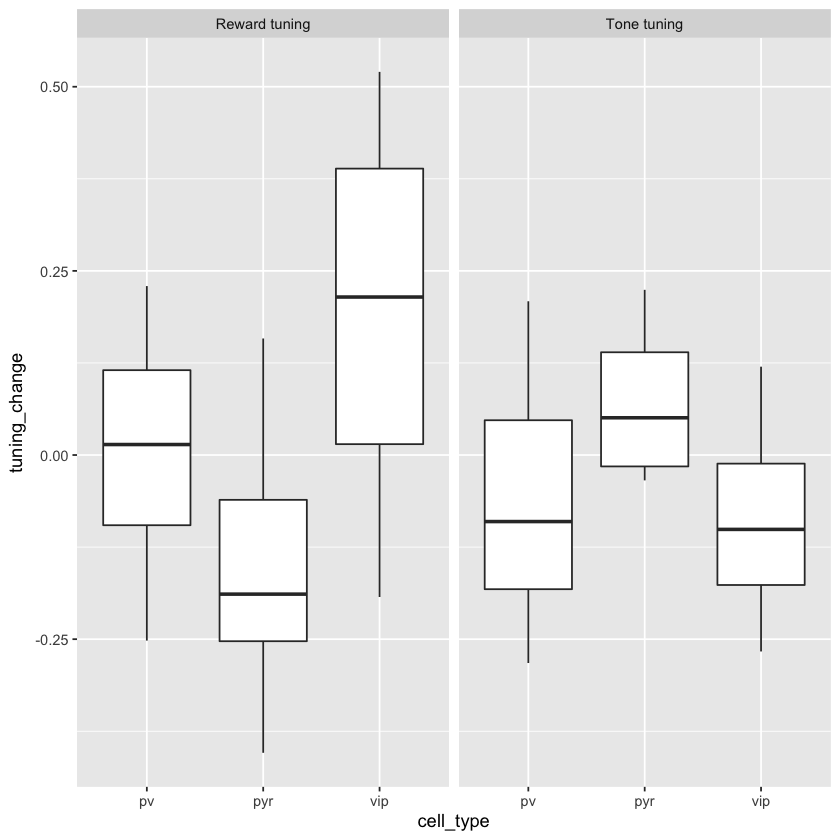

In [13]:
ggplot(median_differences, aes(x=cell_type, y=tuning_change)) +
    facet_grid(cols=vars(trial_component)) +
    geom_boxplot()